# Loading Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import MaxNLocator, FuncFormatter, PercentFormatter
import pycountry_convert as pc


olymp = pd.read_csv("data/athlete_events.csv")
noc_regions = pd.read_csv("data/noc_regions.csv")
olymp.head(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


# Defining Questions

1. How has athlete participation changed over time across countries and continents? 
2. Which countries dominate Olympic performance, and how has dominance shifted over time?
3. Can we predict how many medals a country will win based on its delegation size and historical characteristics? ( fit a poisson regression model (?) )

# Data Collection

Our work uses the dataset titled 120 years of Olympic history: athletes and results on kaggle (https://www.kaggle.com/datasets/heesoo37/120-years-of-olympic-history-athletes-and-results). This is a public dataset that contaians information information since 1896 to 2016. The dataset has 271,116 rows where each row is corresponds to an individual athlete.

# Data Cleaning and Preparation

Talk about the steps we took mapping noc to actual country name and continent.
We also take only the summer olympics.
We will have to standardize country and region information, handle missing/problematic values, and aggregate data to country year summaries that we need for medal trends and participation.

Many demographic values contain missing entries. However, because our main research questions do not heavily rely on these features, and imputing historical physical data might introduce bias, we choose to exclude them from our analysis. The most important variables like Year, NOC, Medal, and Sex are all available.

In [31]:
import pycountry_convert as pc # pip install pycountry pycountry_convert

def country_to_continent(country):
    """
    Convert country name → continent name using pycountry_convert.
    Returns None if lookup fails.
    """
    try:
        iso = pc.country_name_to_country_alpha2(country)
        cont_code = pc.country_alpha2_to_continent_code(iso)
        return {
            "AF": "Africa",
            "AS": "Asia",
            "EU": "Europe",
            "NA": "North America",
            "OC": "Oceania",
            "SA": "South America"
        }[cont_code]
    except:
        return None

manual_continent_overrides = {
    "Serbia and Montenegro": "Europe",
    "Yugoslavia": "Europe",
    "Czechoslovakia": "Europe",
    "Syria": "Asia",
    "Hong Kong": "Asia",
    "Curacao": "North America",
    "Virgin Islands, US": "North America",
    "Virgin Islands, British": "North America",
    "West Indies Federation": "North America",
    "Refugee Olympic Team": None,
    "Individual Olympic Athletes": None,
    "NA": None,
}

def resolve_continent(row):
    country = row["country_name"]
    if country in manual_continent_overrides:
        return manual_continent_overrides[country]
    return country_to_continent(country)

In [49]:
olympics_summer = olymp[olymp['Season'] == "Summer"]

# Merge NOC mappings
olympics_summer = olympics_summer.merge(noc_regions, on="NOC", how="left")
olympics_summer.rename(columns={"region": "country_name"}, inplace=True)

olympics_summer["continent"] = olympics_summer.apply(resolve_continent, axis=1)

# Medal quality fields
olympics_summer["has_medal"] = olympics_summer["Medal"].notna().astype(int)
olympics_summer["is_gold"]   = (olympics_summer["Medal"] == "Gold").astype(int)
olympics_summer["is_silver"] = (olympics_summer["Medal"] == "Silver").astype(int)
olympics_summer["is_bronze"] = (olympics_summer["Medal"] == "Bronze").astype(int)

olympics_summer["medal_quality_score"] = (
    3 * olympics_summer["is_gold"]
    + 2 * olympics_summer["is_silver"]
    + 1 * olympics_summer["is_bronze"]
)

# Country-year summary
country_year = (
    olympics_summer.groupby(["Year", "NOC", "country_name", "continent"])
    .agg(
        n_athletes=("ID", lambda x: x.nunique()),
        n_medals=("has_medal", "sum"),
        n_gold=("is_gold", "sum"),
        n_silver=("is_silver", "sum"),
        n_bronze=("is_bronze", "sum"),
        total_medal_quality=("medal_quality_score", "sum")
    )
    .reset_index()
)

# Medal efficiency
country_year["medals_per_athlete"] = (
    country_year["n_medals"] / country_year["n_athletes"]
).replace([float("inf"), -float("inf")], pd.NA)

# Percent of athletes per continent each year
percent_athletes_continent_year = (
    country_year.dropna(subset=['continent'])
      .groupby(['continent','Year'], as_index=False)['n_athletes']
      .sum()
)
percent_athletes_continent_year['pct'] = percent_athletes_continent_year.groupby('Year')['n_athletes'].transform(
    lambda x: x / x.sum()
)


# Data Analysis

# EDA

C:\Users\Owen Schillaci\AppData\Local\Temp\ipykernel_11444\2322790686.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


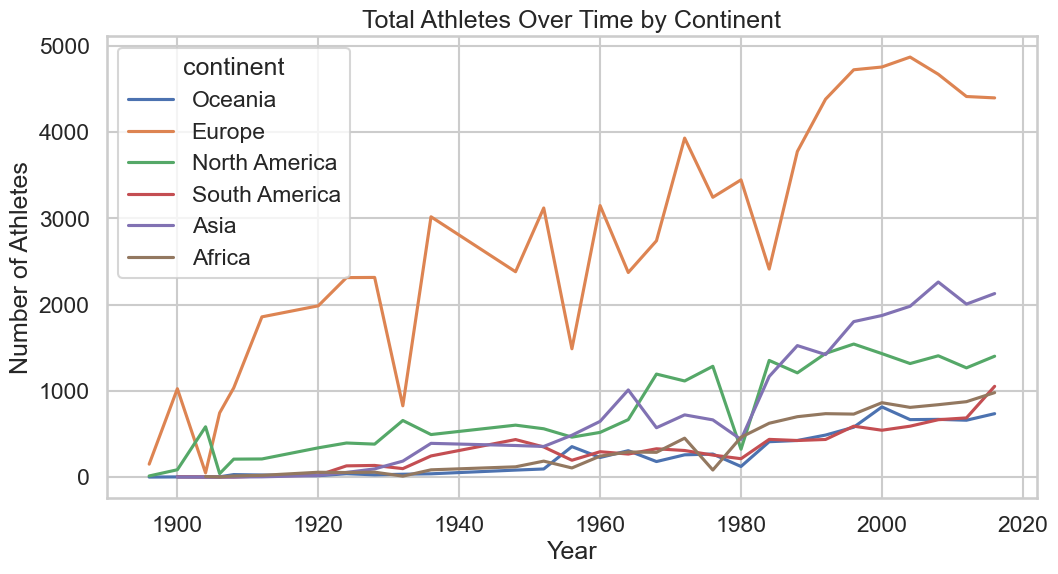

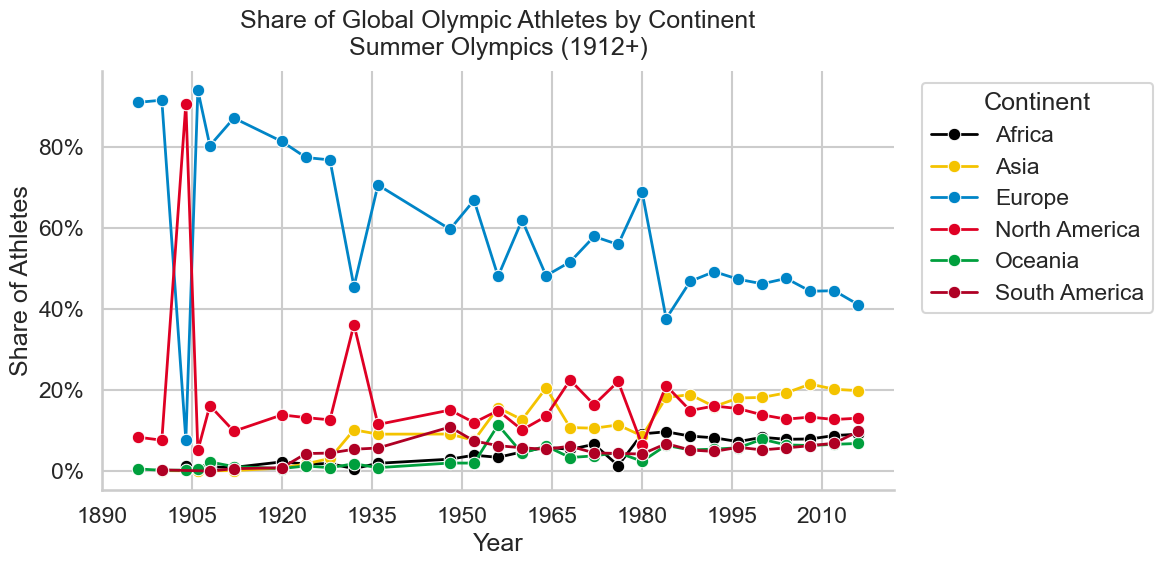

In [50]:
plt.figure(figsize=(12,6))
sns.lineplot(
    data=country_year,
    x="Year",
    y="n_athletes",
    hue="continent",
    estimator="sum",
    ci=None
)
plt.title("Total Athletes Over Time by Continent")
plt.ylabel("Number of Athletes")
plt.show()


continent_colors = {
    "Europe":   "#0085C7",  # Blue
    "Asia":     "#F4C300",  # Yellow
    "Africa":   "#000000",  # Black
    "Oceania":  "#009F3D",  # Green
    "North America": "#DF0024",  # Red
    "South America": "#AF0024", 

}

sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(12,6))
ax = sns.lineplot(data=percent_athletes_continent_year, x='Year', y='pct', hue='continent', marker='o', linewidth=2, palette=continent_colors)
ax.set_title("Share of Global Olympic Athletes by Continent\nSummer Olympics (1912+)", pad=12)
ax.set_xlabel("Year"); ax.set_ylabel("Share of Athletes")
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(title='Continent', bbox_to_anchor=(1.02,1), loc='upper left')
sns.despine(); plt.tight_layout(); plt.show()

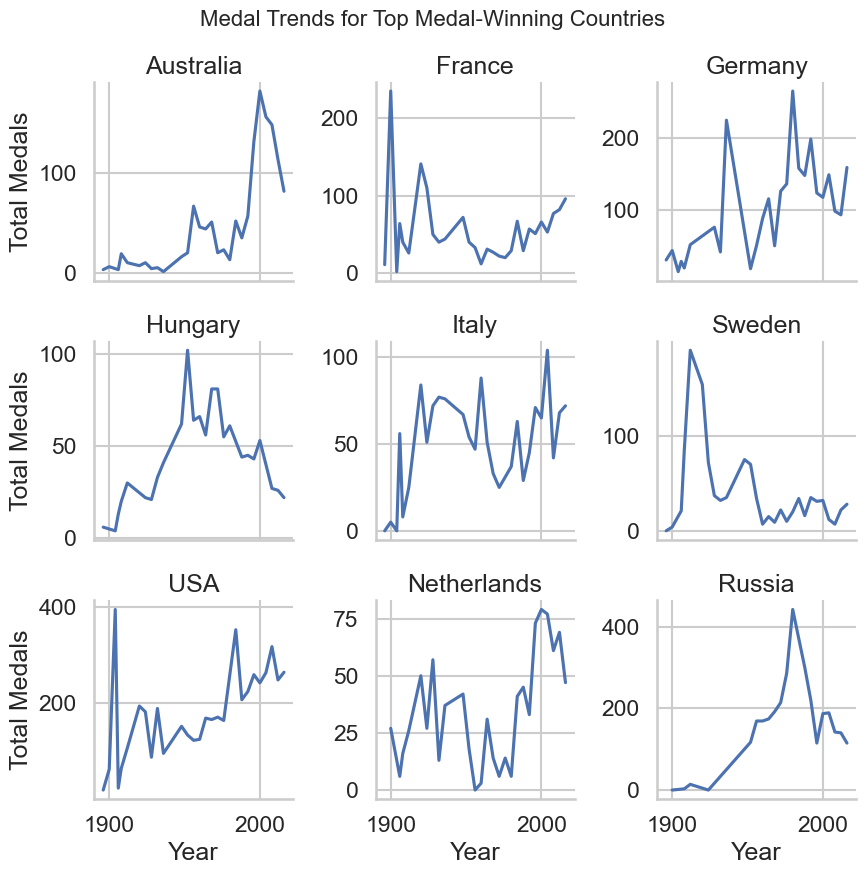

In [53]:
top_countries = (
    country_year.groupby("country_name")["n_medals"]
    .sum()
    .nlargest(9)
    .index
)
facet_df = country_year[country_year["country_name"].isin(top_countries)].copy()

g = sns.FacetGrid(
    facet_df,
    col="country_name",
    col_wrap=3,
    height=3,
    sharey=False
)
g.map_dataframe(sns.lineplot, x="Year", y="n_medals", errorbar=None)
g.set_titles(col_template="{col_name}")
g.set_xlabels("Year")
g.set_ylabels("Total Medals")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Medal Trends for Top Medal-Winning Countries", fontsize=16)
plt.show()

In [54]:
from sklearn.linear_model import LinearRegression

# one-hot encode continent
X = pd.get_dummies(country_year[["Year", "continent"]], drop_first=True)
y = country_year["n_athletes"]

lin_reg = LinearRegression()
lin_reg.fit(X, y)

print("Intercept:", lin_reg.intercept_)
coef_series = pd.Series(lin_reg.coef_, index=X.columns)
print(coef_series)

Intercept: -496.4951640164198
Year                        0.257749
continent_Asia             22.334376
continent_Europe           90.376296
continent_North America    45.401451
continent_Oceania          31.812918
continent_South America    30.010653
dtype: float64
